In [114]:
import numpy as np
import pandas as pd

import allel

In [115]:
height_file="/seq/vgb/vsohrab/darwins_dogs/pnas_behavior_morphology_gwas/input_files/DarwinsArk_AgeComposed_Height_N-3277.tsv"
neuter_file="/seq/vgb/vsohrab/darwins_dogs/pnas_behavior_morphology_gwas/input_files/DarwinsArk_Sex_NeuterStatus_N-3277.tsv"
pheno_file="/seq/vgb/bryc/data/darwins_dogs/2024-09-23_cache/2024-10-15_merged_phenotype_table.csv"
geno_file="/seq/vgb/bryc/data/darwins_dogs/pnas_dog_behavior_paper/target_sites_genotypes.csv"

In [116]:
ph = pd.read_csv(pheno_file)
genos = pd.read_csv(geno_file)
height = pd.read_csv(height_file, sep = "\t",header=None, names = ["fam_id", "dog", "age", "height"])
neuter = pd.read_csv(neuter_file, sep = "\t", header=None, names = ["fam_id", "dog", "sex", "neuter"])

/local/scratch/47595385.1.interactive/ipykernel_31201/975500096.py:1: DtypeWarning: Columns (15,259,260) have mixed types. Specify dtype option on import or set low_memory=False.
  ph = pd.read_csv(pheno_file)


In [160]:
PUREBRED_CUTOFF = 0.85
breeds = ph.columns[19:131]

In [118]:
purebred_dogs = ph.id[ph.purebred == "yes"].to_list()
for breed in breeds:
    purebreds_breed = ph.id[ph[breed] > PUREBRED_CUTOFF].to_list()
    if len(purebreds_breed) > 0:
        purebred_dogs.extend(purebreds_breed)

In [119]:
purebred_to_breed = {each_dog : ph.breed1[ph.id == each_dog].values[0] for each_dog in purebred_dogs}

In [121]:
majority_ancestry = {}
for dog in purebred_dogs:
    for breed in breeds:
        if ph[ph.id == dog][breed].values[0] > 0.85:
            majority_ancestry[dog] = breed

In [122]:
ph["majority_ancestry"] = ph.id.map(majority_ancestry)
ph["self-report breed"] = ph.id.map(purebred_to_breed)

In [123]:
ph["purebred_breed"] = ph["self-report breed"]
ph["purebred_breed"] = ph["purebred_breed"].fillna(ph['majority_ancestry'])

purebred_counts = ph["purebred_breed"].value_counts()
purebred_counts.to_csv("/seq/vgb/bryc/data/darwins_dogs/pnas_dog_behavior_paper/results/purebred_breed_counts_filled.csv")

In [124]:
fst_breeds = purebred_counts[purebred_counts > 20].index.to_list()

In [171]:
fst_df = ph[ph.purebred_breed.isin(fst_breeds)][['id', 'purebred_breed']].copy()
fst_df.shape

purebred_df = pd.merge(fst_df, genos, left_on = "id", right_on = "dog")

In [138]:
subpops = []
for breed in fst_breeds:
    list_of_indexes = np.where(purebred_df.purebred_breed == breed)[0].tolist()
    subpops.append(list_of_indexes)

In [140]:
diploid_map = {0: [0,0], 1: [0,1], 2: [1,1], np.nan: [-1,-1]}
calls =  purebred_df.iloc[:, 3:].astype(int)
g = calls.values.tolist()
list_of_genos = []
for dog in g:
    dog_genos = []
    for genotype in dog:
        dog_genos.append(diploid_map[genotype])
    list_of_genos.append(dog_genos)

In [158]:
geno_df = pd.DataFrame(list_of_genos)
g = geno_df.transpose().values.tolist()

In [190]:
a, b, c = allel.weir_cockerham_fst(g, subpops)
fst = (np.sum(a, axis=1) / (np.sum(a, axis=1) + np.sum(b, axis=1) + np.sum(c, axis=1)))

In [191]:
fst_df = pd.DataFrame(zip(purebred_df.columns[3:], fst), columns = ["Candidate SNP", "Fst"])
candidate_snps = pd.read_csv("/seq/vgb/bryc/projects/dog_behavioral_gwas_paper/data/candidate_SNPs.csv",header=None)
fst_df = fst_df[fst_df["Candidate SNP"].isin(candidate_snps[0])]

In [192]:
fst_df.to_csv("/seq/vgb/bryc/data/darwins_dogs/pnas_dog_behavior_paper/results/candidate_snp_fst.csv", index=False)

In [193]:
fst_df.Fst.mean()

np.float64(0.13083248029416789)

<Axes: >

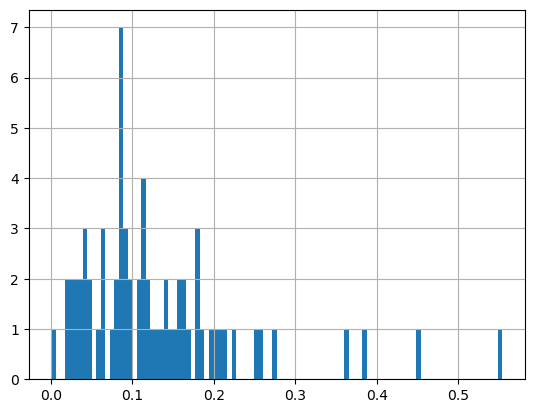

In [199]:
fst_df.Fst.hist(bins = 100)

In [202]:
sum(fst_df.Fst > 0.15)

22

In [203]:
sum(fst_df.Fst > 0.25)

7